# Model Training and Evaluating it

We look to implement and compare five different forecasting models.

In [1]:
#Setting everything up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras import layers, models

sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.data_process import make_supervised_frame, time_series_split
from scripts.data_modeling import compute_regression_metrics, directional_accuracy, make_lstm_sequences

np.random.seed(42)
tf.random.set_seed(42)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

2025-12-11 01:53:06.154772: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 01:53:06.253614: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 01:53:09.995778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 01:53:20.679920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
#Loading data
df = pd.read_csv("../data/sp500.csv", index_col = "Date", parse_dates = True)

df_sup = make_supervised_frame(df, target_col="LogReturn", horizon=1, lags=3)

df_sup.head()

,Close,High,Low,Open,Volume,MA10,MA50,EMA10,EMA50,Return,LogReturn,Volatility20,Momentum10,MACD,MACD_signal,y,LogReturn_lag1,LogReturn_lag2,LogReturn_lag3
Date,,,,,,,,,,,,,,,,,,,
1990-03-13,336.000000,338.670013,335.359985,338.670013,145440000,336.166000,335.755001,335.943020,337.536140,-0.007884,-0.007915,0.007626,5.739990,0.922821,-0.212164,0.002586,0.002187,-0.006901,0.009805
1990-03-14,336.869995,337.630005,334.929993,336.000000,145060000,336.663998,335.298601,336.111561,337.510017,0.002589,0.002586,0.007623,4.979980,0.965092,0.023287,0.003556,-0.007915,0.002187,-0.006901
1990-03-15,338.070007,338.910004,336.869995,336.869995,144410000,337.197000,334.884801,336.467642,337.531977,0.003562,0.003556,0.007632,5.330017,1.082940,0.235218,0.011295,0.002586,-0.007915,0.002187
1990-03-16,341.910004,341.910004,338.070007,338.070007,222520000,337.834000,334.609601,337.457163,337.703664,0.011359,0.011295,0.007797,6.369995,1.469254,0.482025,0.004727,0.003556,0.002586,-0.007915
1990-03-19,343.529999,343.760010,339.119995,341.910004,142300000,338.813000,334.436201,338.561315,337.932148,0.004738,0.004727,0.007628,9.790009,1.884409,0.762502,-0.005722,0.011295,0.003556,0.002586


In [3]:
df_train, df_val, df_test = time_series_split(df_sup, train_frac=0.6, val_frac=0.2)

feature_cols = [c for c in df_sup.columns if c !="y"]

X_train, y_train = df_train[feature_cols], df_train["y"]
X_val, y_val = df_val[feature_cols], df_val["y"]
X_test, y_test = df_test[feature_cols], df_test["y"]

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 5401
Val size: 1800
Test size: 1801


In [4]:
#baseline
y_test_naive = df_test["LogReturn_lag1"]  

baseline_metrics = compute_regression_metrics(y_test, y_test_naive)
baseline_dir_acc = directional_accuracy(y_test, y_test_naive)

print("Naive baseline metrics:", baseline_metrics)
print("Naive baseline directional accuracy:", baseline_dir_acc)

Naive baseline metrics: {'RMSE': np.float64(0.016940516181126818), 'MAE': 0.011609508629903469, 'MAPE': np.float64(55028649.37670717), 'R2': -0.7663663344574858}
Naive baseline directional accuracy: 0.5091615769017213


### Linear Baseline
After the naive baseline, we use a Linear Regression model. According to the Efficient Market Hypothesis (EMH), daily returns should be a random walk, meaning our linear model should have a $R^2$ close to zero. This will be a good indicator of whether complex models can extract any signal.

In [7]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_val_lr = linreg.predict(X_val)
y_test_lr = linreg.predict(X_test)

lr_val_metrics = compute_regression_metrics(y_val, y_val_lr)
lr_test_metrics = compute_regression_metrics(y_test, y_test_lr)
lr_dir_acc = directional_accuracy(y_test, y_test_lr)

print("Linear Regression – Validation Metrics:", lr_val_metrics)
print("Linear Regression – Test Metrics:", lr_test_metrics)
print(f"Linear Regression – Directional Accuracy: {lr_dir_acc:.2%}")

Linear Regression – Validation Metrics: {'RMSE': np.float64(0.008868328927820853), 'MAE': 0.0063761811065348156, 'MAPE': np.float64(25170226.8610912), 'R2': -0.07698636794799141}
Linear Regression – Test Metrics: {'RMSE': np.float64(0.013779692199568672), 'MAE': 0.01000555712100086, 'MAPE': np.float64(37904336.9105921), 'R2': -0.168709391110629}
Linear Regression – Directional Accuracy: 46.42%


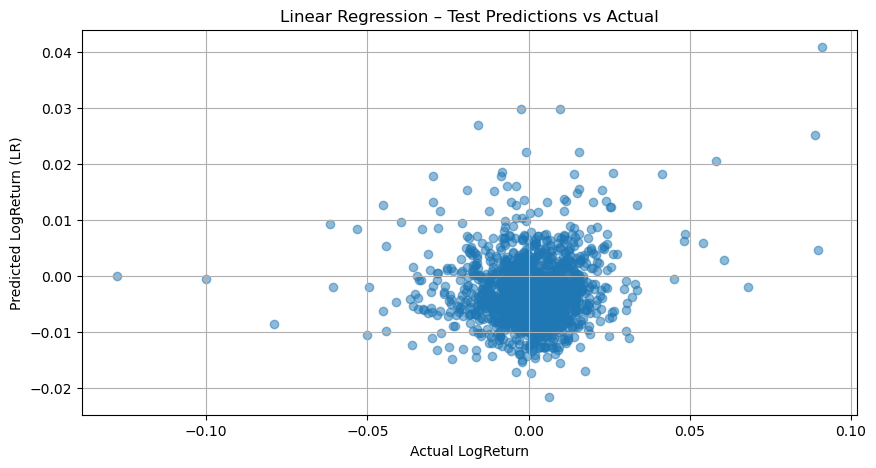

In [8]:
plt.scatter(y_test, y_test_lr, alpha=0.5)
plt.xlabel("Actual LogReturn")
plt.ylabel("Predicted LogReturn (LR)")
plt.title("Linear Regression – Test Predictions vs Actual")
plt.savefig("../images/LR.png")
plt.show()

The Linear Regression model had an $R^2$ score of -0.17. So, this implies the model performs worse than just guessing the average return. 

In [16]:
rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

y_val_rf = rf.predict(X_val)
y_test_rf = rf.predict(X_test)

rf_val_metrics = compute_regression_metrics(y_val, y_val_rf)
rf_test_metrics = compute_regression_metrics(y_test, y_test_rf)
rf_dir_acc = directional_accuracy(y_test, y_test_rf)

print("Random Forest – validation metrics:", rf_val_metrics)
print("Random Forest – test metrics:", rf_test_metrics)
print("Random Forest – test directional accuracy:", rf_dir_acc)

Random Forest – validation metrics: {'RMSE': np.float64(0.008777587376121151), 'MAE': 0.006023936541851092, 'MAPE': np.float64(28279760.06041696), 'R2': -0.05505947798625388}
Random Forest – test metrics: {'RMSE': np.float64(0.014802500689598751), 'MAE': 0.009275967638213678, 'MAPE': np.float64(46582102.705459595), 'R2': -0.3486451046490677}
Random Forest – test directional accuracy: 0.538034425319267


The Random Forest model has $R^2 \approx -0.35$. This is worse off than Linear Regression model.

/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/.local/share/envs/final-group13/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is

ARIMA metrics (val+test window): {'RMSE': np.float64(0.010885095016858535), 'MAE': 0.007145005319635196, 'MAPE': np.float64(34330705.82097801), 'R2': -0.0008942902664539343}
ARIMA directional accuracy: 0.5456563974465723


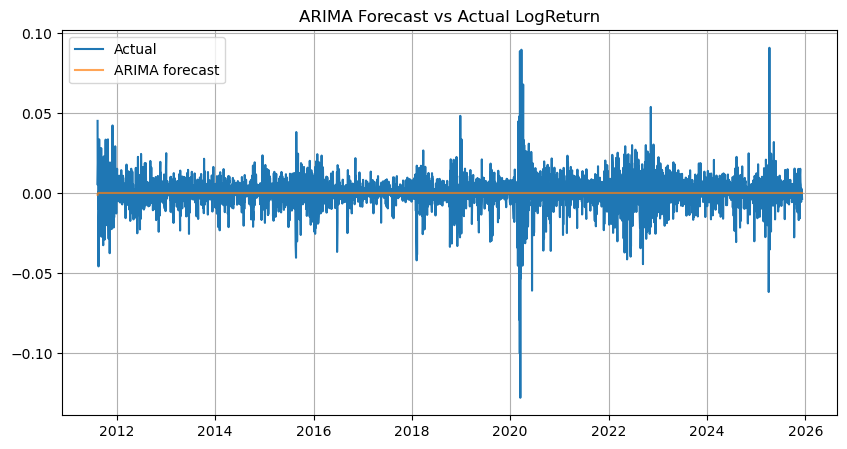

In [10]:
# 10. ARIMA baseline (simplified, univariate)


# We'll model LogReturn as a univariate series
logret_series = df["LogReturn"].dropna()

# Align with df_sup range (so we're forecasting over the same overall period)
logret_aligned = logret_series.loc[df_sup.index]

train_end_idx = df_train.index[-1]
val_end_idx = df_val.index[-1]

logret_train = logret_aligned.loc[:train_end_idx]
logret_val = logret_aligned.loc[train_end_idx:val_end_idx]
logret_test = logret_aligned.loc[val_end_idx:]

# Fit a simple ARIMA(1,0,1) on the training portion
arima_model = ARIMA(logret_train, order=(1, 0, 1))
arima_result = arima_model.fit()

# Forecast over validation + test window
n_forecast = len(logret_val) + len(logret_test)
arima_forecast = arima_result.forecast(steps=n_forecast)

# Take the last n_forecast actual values to compare against
logret_val_test = logret_aligned.iloc[-n_forecast:]

# --- Clean and align for metrics (avoid NaNs) ---

# Put both into arrays
y_true = logret_val_test.to_numpy()
y_pred = np.asarray(arima_forecast)

# In case lengths differ for any reason, clip to the shorter one
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Drop any NaNs that might still be present
mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]

# Compute metrics
arima_metrics = compute_regression_metrics(y_true_clean, y_pred_clean)
arima_dir_acc = directional_accuracy(y_true_clean, y_pred_clean)

print("ARIMA metrics (val+test window):", arima_metrics)
print("ARIMA directional accuracy:", arima_dir_acc)

# Plot actual vs forecast on the same time index
plot_index = logret_val_test.index[:len(y_true_clean)]
plt.plot(plot_index, y_true_clean, label="Actual")
plt.plot(plot_index, y_pred_clean, label="ARIMA forecast", alpha=0.7)
plt.legend()
plt.title("ARIMA Forecast vs Actual LogReturn")
plt.savefig("../images/ARIMA.png")
plt.show()

The ARIMA model has $R^2 \approx -0.0009$. This is far better than our linear baseline.

In [11]:
#LTSM Data Prep
tf.random.set_seed(42)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

SEQ_LEN = 30
X_train_lstm, y_train_lstm = make_lstm_sequences(X_train_sc, y_train.values, SEQ_LEN)
X_val_lstm, y_val_lstm = make_lstm_sequences(X_val_sc, y_val.values, SEQ_LEN)
X_test_lstm, y_test_lstm = make_lstm_sequences(X_test_sc, y_test.values, SEQ_LEN)

2025-12-11 01:55:28.393109: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0066 - val_loss: 4.7753e-04
Epoch 2/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012 - val_loss: 3.9340e-04
Epoch 3/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.4524e-04 - val_loss: 1.7822e-04
Epoch 4/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.0324e-04 - val_loss: 9.1113e-05
Epoch 5/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.1936e-04 - val_loss: 7.6343e-05
Epoch 6/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.5205e-04 - val_loss: 7.1253e-05
Epoch 7/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1402e-04 - val_loss: 6.9024e-05
Epoch 8/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0618e-04 - val_loss: 6.9460e-05
Epoch 9/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8815e-04 - val_loss: 7.0081e-05
Epoch 10/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7364e-04 - val_loss: 6.9981e-05
Epoch 11/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.

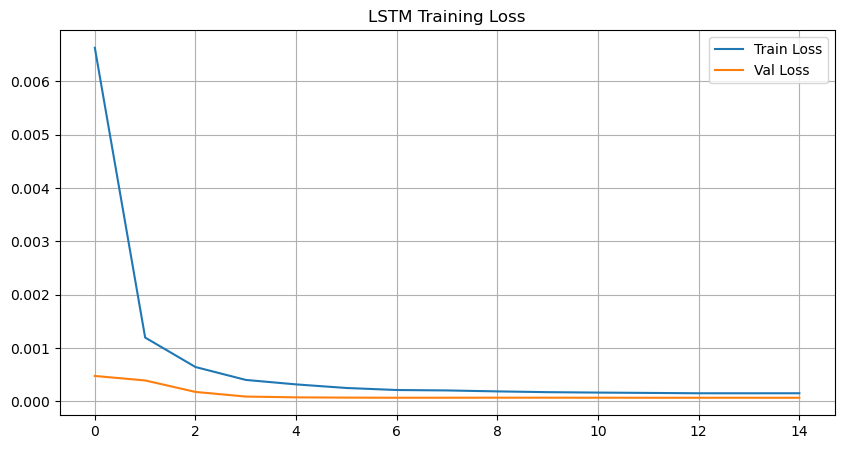

In [12]:
#LTSM Build
model = models.Sequential([
    layers.Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=15,
    batch_size=32,
    verbose=1
)

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Training Loss')
plt.legend()
plt.savefig("../images/lstm_training_curve.png")
plt.show()

In [13]:
#LSTM evaluations
y_pred_lstm = model.predict(X_test_lstm).flatten()

lstm_metrics = compute_regression_metrics(y_test_lstm, y_pred_lstm)
lstm_dir_acc = directional_accuracy(y_test_lstm, y_pred_lstm)

print("LSTM Metrics:", lstm_metrics)
print(f"Directional Accuracy: {lstm_dir_acc:.2%}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Metrics: {'RMSE': np.float64(0.01594281443908124), 'MAE': 0.010460818840851595, 'MAPE': np.float64(44365453.31211706), 'R2': -0.5736688689582898}
Directional Accuracy: 49.24%


In [14]:
summary_rows = []

summary_rows.append(
    {"Model": "Naive",
     **baseline_metrics,
     "DirAcc": baseline_dir_acc}
)

summary_rows.append(
    {"Model": "LinearRegression",
     **lr_test_metrics,
     "DirAcc": lr_dir_acc}
)

summary_rows.append(
    {"Model": "RandomForest",
     **rf_test_metrics,
     "DirAcc": rf_dir_acc}
)

summary_rows.append(
    {"Model": "ARIMA(1,0,1)",
     **arima_metrics,
     "DirAcc": arima_dir_acc}
)

summary_rows.append(
    {"Model": "LSTM",
     **lstm_metrics,
     "DirAcc": lstm_dir_acc}
)

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("../data/final_metrics.csv")
summary_df.head()

,Model,RMSE,MAE,MAPE,R2,DirAcc
0,Naive,0.016941,0.011610,5.502865e+07,-0.766366,0.509162
1,LinearRegression,0.013780,0.010006,3.790434e+07,-0.168709,0.464187
2,RandomForest,0.019296,0.015812,5.571611e+07,-1.291640,0.463631
3,"ARIMA(1,0,1)",0.010885,0.007145,3.433071e+07,-0.000894,0.545656
4,LSTM,0.015943,0.010461,4.436545e+07,-0.573669,0.492377


/tmp/ipykernel_753/602907317.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(summary_df["Model"], rotation=45, ha="right")
/tmp/ipykernel_753/602907317.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(summary_df["Model"], rotation=45, ha="right")


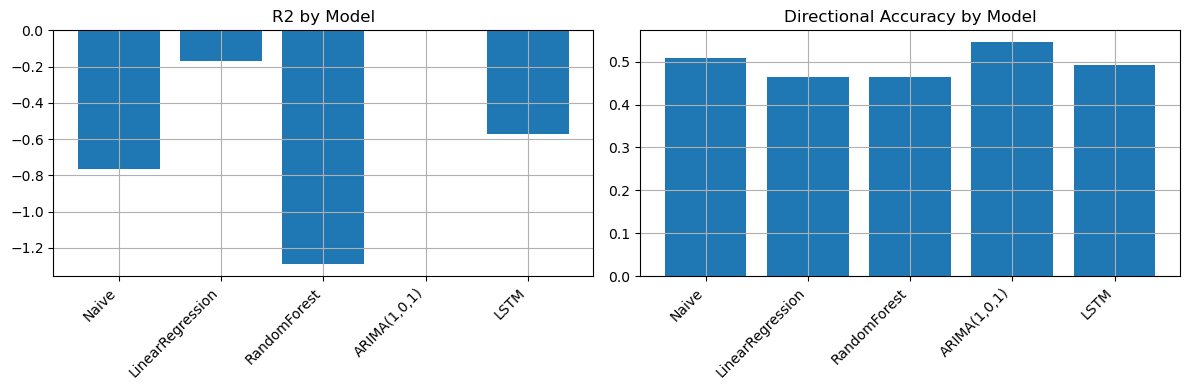

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(summary_df["Model"], summary_df["R2"])
axes[0].set_title("R2 by Model")
axes[0].set_xticklabels(summary_df["Model"], rotation=45, ha="right")

axes[1].bar(summary_df["Model"], summary_df["DirAcc"])
axes[1].set_title("Directional Accuracy by Model")
axes[1].set_xticklabels(summary_df["Model"], rotation=45, ha="right")

plt.tight_layout()
plt.savefig("../images/R2_Accuracy.png")
plt.show()

All our models find it difficult to capture the true nature of returns in the stock market. However, ARIMA clearly is the best model.